In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

#Número Top de Gens. En aquest cas vull els TOP100
n=100

#Fitxer que contè en TPM els gens codifcants de PROTEÏNES més epxressats de manera ordenada decreixent.
teixits = pd.read_csv('D:/TFM/ANALISI_MODELS/Datasets/all_gensTPM_noversio_PROTEIN_ZA.csv',sep =",")

In [2]:
#data = teixits.iloc[:, 1:4]
data=teixits

In [3]:
if (n==0 or n>(len(teixits.columns)-3)):
    n=len(teixits.columns)-3
    
data = teixits.iloc[:, 2:n+3]

In [4]:
data

,SMTSD,ENSG00000198712,ENSG00000198899,ENSG00000198938,ENSG00000198804,ENSG00000198886,ENSG00000198763,ENSG00000198888,ENSG00000198727,ENSG00000228253,...,ENSG00000110700,ENSG00000174444,ENSG00000113140,ENSG00000133169,ENSG00000109475,ENSG00000167815,ENSG00000104964,ENSG00000176340,ENSG00000177600,ENSG00000067225
0,Brain - Cortex,59480,57190,43790,51600,48610,32840,36570,32050,32400,...,338.6,377.1,77.16,425.0,306.5,493.6,408.2,356.1,344.0,503.0
1,Brain - Cerebellum,49380,50440,37730,27340,45150,25620,30180,30980,32770,...,469.7,480.2,533.10,412.2,379.3,685.3,762.1,535.4,378.5,595.0
2,Brain - Cortex,62980,66050,48110,75880,63390,32590,45930,31380,30880,...,243.0,281.4,82.81,409.7,251.7,456.9,474.9,374.1,253.6,476.8
3,Brain - Cerebellum,51110,50770,43170,60530,54370,28230,36340,31450,26920,...,456.8,396.9,163.60,285.5,450.9,510.0,633.7,456.1,351.9,452.5
4,Brain - Cortex,62790,47390,56100,70590,45050,36770,38690,29500,28460,...,256.2,279.7,204.20,673.1,279.9,655.9,591.7,529.5,321.1,687.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,Brain - Cortex,60430,54270,52260,54240,42870,26570,36790,26310,35480,...,248.7,318.4,101.40,627.6,247.8,646.7,586.4,484.1,274.6,695.8
2637,Brain - Cerebellum,44910,49800,38950,39790,52370,29630,35390,31610,24780,...,481.1,467.5,484.50,347.0,422.5,523.8,651.5,462.8,348.9,521.1
2638,Brain - Cortex,47760,49580,42730,51040,50630,38830,40840,30990,28390,...,467.8,450.9,247.70,318.3,457.5,362.9,362.1,357.4,447.6,409.2
2639,Brain - Cerebellum,56890,60010,41590,33670,46580,38390,42170,42080,37540,...,493.0,367.1,1149.00,225.6,377.9,389.1,611.0,391.6,356.0,369.3


In [5]:
#Creació conjunt train i test

x,y=data.iloc[:, 1:n+1],data.iloc[:, 0]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=123)

x_train = np.log2(x_train+1)
x_test = np.log2(x_test+1)

In [6]:
#Definim PCA

pca = PCA()

z= pca.fit_transform(x_train)

x_train_pca = z
x_test_pca  = pca.transform(x_test)

14 components expliquen un 95% de la variança. De 100 dimensions a 14


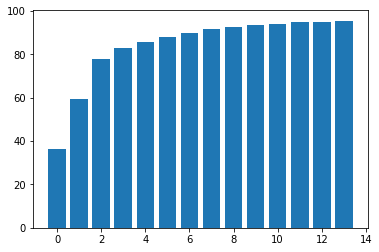

In [7]:
total = sum(pca.explained_variance_)

k = 0
current_variance = 0
while current_variance/total < 0.95:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " components expliquen un 95% de la variança. De ",n," dimensions a ", k, sep='')

pca = PCA(n_components=k)

x_train.pca = pca.fit(x_train)
x_train_pca = pca.transform(x_train)

x_test_pca = pca.transform(x_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

In [8]:
#Dinàmicament agafo el numero de Dimensions de PCA: k

principalDf = pd.DataFrame(data = x_train_pca[:,0:k])
             #, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.991514,-3.715432,-1.463150,-1.125784,0.184376,-1.310509,-0.750647,-1.745442,0.387357,0.202032,0.005190,1.674778,-1.579811,-1.050294
1,-3.168115,4.231422,6.712155,2.254446,-0.591467,-1.013384,0.234546,-0.246699,-0.458270,0.248543,-0.194882,-0.480406,-0.794660,-0.138042
2,8.074628,-3.374665,3.653102,-4.058980,2.560930,3.916829,3.576648,-0.093946,-2.676133,-2.308562,1.509702,0.742629,-0.287113,1.535345
3,14.717564,-3.419392,3.277168,0.896257,-0.199588,-0.171130,0.054898,0.564828,1.141969,-0.673222,0.735794,0.504036,-0.601007,-0.319414
4,4.183859,-4.501926,-0.326770,-0.110364,-0.351499,-1.717121,2.469997,-0.174397,-0.658247,-0.151656,0.919058,-0.433728,0.594179,0.210834


In [9]:
x_train_pca[:,0:11].shape

(2112, 11)

In [10]:
principalDf.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

finalDF = pd.concat([principalDf, y_train], axis=1)

finalDF.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,SMTSD
0,1.991514,-3.715432,-1.463150,-1.125784,0.184376,-1.310509,-0.750647,-1.745442,0.387357,0.202032,0.005190,1.674778,-1.579811,-1.050294,Brain - Hippocampus
1,-3.168115,4.231422,6.712155,2.254446,-0.591467,-1.013384,0.234546,-0.246699,-0.458270,0.248543,-0.194882,-0.480406,-0.794660,-0.138042,Brain - Cerebellum
2,8.074628,-3.374665,3.653102,-4.058980,2.560930,3.916829,3.576648,-0.093946,-2.676133,-2.308562,1.509702,0.742629,-0.287113,1.535345,Brain - Frontal Cortex (BA9)
3,14.717564,-3.419392,3.277168,0.896257,-0.199588,-0.171130,0.054898,0.564828,1.141969,-0.673222,0.735794,0.504036,-0.601007,-0.319414,Brain - Nucleus accumbens (basal ganglia)
4,4.183859,-4.501926,-0.326770,-0.110364,-0.351499,-1.717121,2.469997,-0.174397,-0.658247,-0.151656,0.919058,-0.433728,0.594179,0.210834,Brain - Frontal Cortex (BA9)


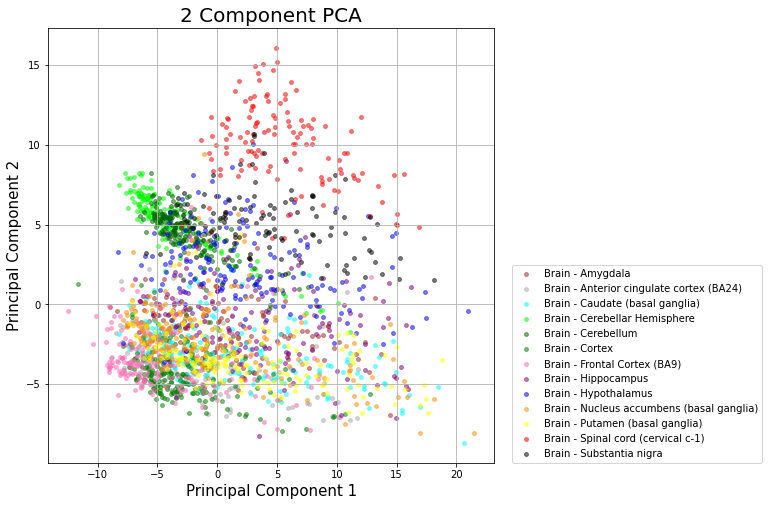

In [11]:
#Visualitzo la projecció 2D

fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = ['Brain - Amygdala',
           'Brain - Anterior cingulate cortex (BA24)',
           'Brain - Caudate (basal ganglia)',
           'Brain - Cerebellar Hemisphere',
           'Brain - Cerebellum',
           'Brain - Cortex',
           'Brain - Frontal Cortex (BA9)',
           'Brain - Hippocampus', 
           'Brain - Hypothalamus',       
           'Brain - Nucleus accumbens (basal ganglia)', 
           'Brain - Putamen (basal ganglia)',
           'Brain - Spinal cord (cervical c-1)',
           'Brain - Substantia nigra']

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 13))

colors = {'red':   ((0.0, 0.0, 0.0),
                    (0.5, 0.0, 0.1),
                    (1.0, 1.0, 1.0)),

          'green': ((0.0, 0.0, 0.0),
                    (1.0, 0.0, 0.0)),

          'blue':  ((0.0, 0.0, 1.0),
                    (0.5, 0.1, 0.0),
                    (1.0, 0.0, 0.0))
          }

colors = {"black","hotpink", "purple", "green","lime", "blue", "red","yellow","cyan", "darkgreen","darkorange", "brown", "darkgrey"}

for target, color in zip(targets,colors):
    indicesToKeep = finalDF['SMTSD'] == target    
    ax.scatter(finalDF.loc[indicesToKeep, 0]
               , finalDF.loc[indicesToKeep, 1]
               , c = color               
               , s = 15, alpha=0.5)
ax.legend(targets, loc=(1.04,0))


ax.grid()

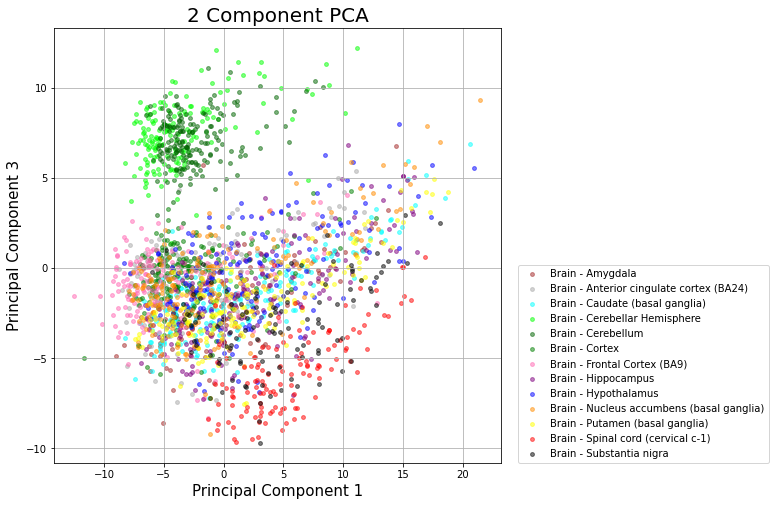

In [12]:

fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = ['Brain - Amygdala',
           'Brain - Anterior cingulate cortex (BA24)',
           'Brain - Caudate (basal ganglia)',
           'Brain - Cerebellar Hemisphere',
           'Brain - Cerebellum',
           'Brain - Cortex',
           'Brain - Frontal Cortex (BA9)',
           'Brain - Hippocampus', 
           'Brain - Hypothalamus',       
           'Brain - Nucleus accumbens (basal ganglia)', 
           'Brain - Putamen (basal ganglia)',
           'Brain - Spinal cord (cervical c-1)',
           'Brain - Substantia nigra']

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 13))

colors = {'red':   ((0.0, 0.0, 0.0),
                    (0.5, 0.0, 0.1),
                    (1.0, 1.0, 1.0)),

          'green': ((0.0, 0.0, 0.0),
                    (1.0, 0.0, 0.0)),

          'blue':  ((0.0, 0.0, 1.0),
                    (0.5, 0.1, 0.0),
                    (1.0, 0.0, 0.0))
          }

colors = {"black","hotpink", "purple", "green","lime", "blue", "red","yellow","cyan", "darkgreen","darkorange", "brown", "darkgrey"}

for target, color in zip(targets,colors):
    indicesToKeep = finalDF['SMTSD'] == target    
    ax.scatter(finalDF.loc[indicesToKeep, 0]
               , finalDF.loc[indicesToKeep, 2]
               , c = color               
               , s = 15, alpha=0.5)
ax.legend(targets, loc=(1.04,0))


ax.grid()

<b>tSNE Perplexity 30</b>

In [13]:
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1, random_state=1234)

points = tsne.fit_transform(x_train)

tsne_df = pd.DataFrame({'X':points[:,0],
                        'Y':points[:,1],
                        'Tipus Teixit':y_train})
tsne_df.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2112 samples in 0.000s...
[t-SNE] Computed neighbors for 2112 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2112
[t-SNE] Computed conditional probabilities for sample 2000 / 2112
[t-SNE] Computed conditional probabilities for sample 2112 / 2112
[t-SNE] Mean sigma: 1.938240
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.969978
[t-SNE] KL divergence after 1000 iterations: 0.973333


,X,Y,Tipus Teixit
0,-0.133613,-5.672159,Brain - Hippocampus
1,-61.510612,17.317707,Brain - Cerebellum
2,9.721541,25.170750,Brain - Frontal Cortex (BA9)
3,-1.963696,28.257908,Brain - Nucleus accumbens (basal ganglia)
4,-10.313346,1.682261,Brain - Frontal Cortex (BA9)


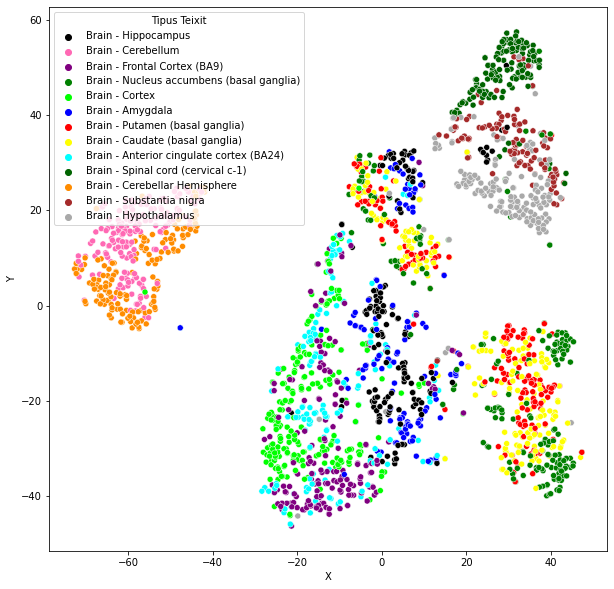

In [14]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x="X", y="Y",
              hue="Tipus Teixit",
              palette=["black","hotpink", "purple", "green","lime", "blue", "red","yellow","cyan", "darkgreen","darkorange", "brown", "darkgrey"],
              #legend='full',              
              data=tsne_df);

<b>Realització de Models</b>

<b>Model Classificador kNN</b>

In [15]:
#Emprant Reducció PCA
#============================

# Grid d'hiperparàmetres
# ==============================================================================
param_grid={"n_neighbors":range(5,25), "weights": ["uniform","distance"]}


# Validació creuada
# ==============================================================================
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()


grid = GridSearchCV(model , param_grid = param_grid,
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,                           
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)


# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)


# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(kNN) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model2 = grid.best_estimator_

r_model2 = grid.best_score_

# Prediccions test
# ==============================================================================

prediccions2 = model2.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy2 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions2,
            normalize = True
           )
print("")
print(f"(kNN) El accuracy de test és: {100*accuracy2}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions2,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 40 candidates, totalling 400 fits
40 # Prec. mitjana:  70.50165429670034  desv.:  3.2557211591180217  paràmetres:  {'n_neighbors': 5, 'weights': 'uniform'}
39 # Prec. mitjana:  71.06992756863096  desv.:  3.1022565698051117  paràmetres:  {'n_neighbors': 5, 'weights': 'distance'}
36 # Prec. mitjana:  71.59170169006528  desv.:  2.684635948063932  paràmetres:  {'n_neighbors': 6, 'weights': 'uniform'}
30 # Prec. mitjana:  72.0171242063847  desv.:  2.928364211254794  paràmetres:  {'n_neighbors': 6, 'weights': 'distance'}
31 # Prec. mitjana:  71.82844496110168  desv.:  2.4081997495136314  paràmetres:  {'n_neighbors': 7, 'weights': 'uniform'}
18 # Prec. mitjana:  72.44321738352856  desv.:  2.6844117784784727  paràmetres:  {'n_neighbors': 7, 'weights': 'distance'}
32 # Prec. mitjana:  71.78216936421353  desv.:  3.244843496706335  paràmetres:  {'n_neighbors': 8, 'weights': 'uniform'}
15 # Prec. mitjana:  72.6343557185013  desv.:  2.8461845597203643  paràmetres:  {'n_

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,21,1,1,0,0,0,0,11,0,0,0,0,0
Brain - Anterior cingulate cortex (BA24),2,12,0,0,0,5,8,1,0,0,0,0,0
Brain - Caudate (basal ganglia),0,0,38,0,0,0,1,0,0,6,7,0,0
Brain - Cerebellar Hemisphere,0,0,0,42,9,0,0,0,0,0,0,0,0
Brain - Cerebellum,0,0,0,6,49,0,0,0,0,0,0,0,0
Brain - Cortex,0,2,0,0,0,36,2,2,0,0,0,0,0
Brain - Frontal Cortex (BA9),4,5,0,0,0,6,18,0,0,0,0,0,0
Brain - Hippocampus,7,1,1,0,0,0,0,27,1,0,0,2,2
Brain - Hypothalamus,0,0,0,1,0,0,0,1,28,1,0,0,8


<b>SVM</b>

In [16]:
#Emprant Reducció PCA
#============================
# Grid d'hiperparàmetres
# ==============================================================================
param_grid = {"C": (0.01, 0.1, 1, 10, 100, 150, 200, 250 , 300, 1000), "gamma": (0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.005, 0.1,0.5, 1, 10)}

# Validació creuada
# ==============================================================================
from sklearn import svm

model = svm.SVC()
grid = GridSearchCV(model, param_grid = param_grid,                           
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)

    
# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(SVM) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model3 = grid.best_estimator_

r_model3 = grid.best_score_


# Prediccions test
# ==============================================================================

prediccions3 = model3.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy3 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions3,
            normalize = True
           )
print("")
print(f"(SVM) El accuracy de test és: {100*accuracy3}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions3,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 1e-06}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 1e-05}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 0.0001}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 0.001}
74 # Prec. mitjana:  18.74988822319592  desv.:  0.3054969458147826  paràmetres:  {'C': 0.01, 'gamma': 0.01}
75 # Prec. mitjana:  18.56076187069659  desv.:  0.41809688853056276  paràmetres:  {'C': 0.01, 'gamma': 0.005}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 0.1}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 0.5}
76 # Prec. mitjana:  10.038004113386389  desv.:  0.195

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,24,1,0,0,0,0,0,9,0,0,0,0,0
Brain - Anterior cingulate cortex (BA24),2,22,0,0,0,0,4,0,0,0,0,0,0
Brain - Caudate (basal ganglia),0,0,44,0,0,0,1,0,0,2,5,0,0
Brain - Cerebellar Hemisphere,0,0,0,48,3,0,0,0,0,0,0,0,0
Brain - Cerebellum,0,0,0,0,55,0,0,0,0,0,0,0,0
Brain - Cortex,0,0,0,0,0,42,0,0,0,0,0,0,0
Brain - Frontal Cortex (BA9),1,2,0,0,0,1,29,0,0,0,0,0,0
Brain - Hippocampus,6,5,1,0,0,0,0,28,1,0,0,0,0
Brain - Hypothalamus,0,0,0,1,0,0,0,0,31,1,0,1,5


<b>Arbres de decisió</b>

In [17]:
#Emprant Reducció PCA
#============================

# Grid d'hiperparàmetres
# ==============================================================================
param_grid={'min_samples_split' :(2, 10, 20, 50 ,75,100,500,1000),'max_depth':(4,5,6,7,8,9,10,20,50,100,200,300,400,450,460,470,500,550,600,650,700,1000)}

# Validació creuada
# ==============================================================================
import sklearn.tree

model=sklearn.tree.DecisionTreeClassifier()

grid = GridSearchCV(model, param_grid = param_grid, 
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)


# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)


# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(Arbre de Decissió) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model4 = grid.best_estimator_

r_model4 = grid.best_score_

# Prediccions test
# ==============================================================================

prediccions4 = model4.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy4 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions4,
            normalize = True
           )
print("")
print(f"(Arbre de Decissió) El accuracy de test és: {100*accuracy4}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions4,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 176 candidates, totalling 1760 fits
127 # Prec. mitjana:  46.6864884199231  desv.:  4.812125135610625  paràmetres:  {'max_depth': 4, 'min_samples_split': 2}
127 # Prec. mitjana:  46.6864884199231  desv.:  4.844688500437923  paràmetres:  {'max_depth': 4, 'min_samples_split': 10}
127 # Prec. mitjana:  46.6864884199231  desv.:  4.844688500437923  paràmetres:  {'max_depth': 4, 'min_samples_split': 20}
130 # Prec. mitjana:  46.260171689171074  desv.:  4.9528379784896615  paràmetres:  {'max_depth': 4, 'min_samples_split': 50}
132 # Prec. mitjana:  46.21277832424216  desv.:  4.944027461395343  paràmetres:  {'max_depth': 4, 'min_samples_split': 75}
131 # Prec. mitjana:  46.25994813556291  desv.:  4.896536173892601  paràmetres:  {'max_depth': 4, 'min_samples_split': 100}
154 # Prec. mitjana:  38.54220692121971  desv.:  1.871619872957356  paràmetres:  {'max_depth': 4, 'min_samples_split': 500}
155 # Prec. mitjana:  29.876151301082  desv.:  1.278042037418382  paràmetr

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,20,2,0,1,0,1,0,7,2,0,1,0,0
Brain - Anterior cingulate cortex (BA24),5,8,2,0,0,4,9,0,0,0,0,0,0
Brain - Caudate (basal ganglia),2,3,30,0,0,0,0,1,0,7,9,0,0
Brain - Cerebellar Hemisphere,0,0,0,39,9,0,0,0,0,1,0,1,1
Brain - Cerebellum,0,0,1,8,45,0,0,0,1,0,0,0,0
Brain - Cortex,0,2,0,0,0,34,3,1,0,2,0,0,0
Brain - Frontal Cortex (BA9),0,6,3,0,0,3,19,1,0,1,0,0,0
Brain - Hippocampus,3,2,2,0,0,1,5,21,3,0,3,0,1
Brain - Hypothalamus,2,1,0,0,0,1,0,1,27,2,0,0,5


<b>Random Forest</b>

In [18]:
#Emprant Reducció PCA
#============================

# Grid d'hiperparàmetres
# ==============================================================================
param_grid={'n_estimators' :(10, 50 ,100 ,200, 250, 400),'max_depth':(6,7,8,9,10,11,12,15,20,25,30)}

# Validació creuada
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

grid = GridSearchCV(model, param_grid = param_grid, 
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)


# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)


# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(Random Forest) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model5 = grid.best_estimator_

r_model5 = grid.best_score_


# Prediccions test
# ==============================================================================

prediccions5 = model5.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy5 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions5,
            normalize = True
           )
print("")
print(f"(Random Forest) El accuracy de test és: {100*accuracy5}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions5,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 66 candidates, totalling 660 fits
66 # Prec. mitjana:  70.21729410712689  desv.:  1.436888864343909  paràmetres:  {'max_depth': 6, 'n_estimators': 10}
55 # Prec. mitjana:  74.38500402396494  desv.:  3.3551103141849823  paràmetres:  {'max_depth': 6, 'n_estimators': 50}
52 # Prec. mitjana:  75.19002056693196  desv.:  3.203366573106152  paràmetres:  {'max_depth': 6, 'n_estimators': 100}
51 # Prec. mitjana:  75.28480729678977  desv.:  3.296654064750937  paràmetres:  {'max_depth': 6, 'n_estimators': 200}
53 # Prec. mitjana:  75.09501028346597  desv.:  3.6390843324143676  paràmetres:  {'max_depth': 6, 'n_estimators': 250}
50 # Prec. mitjana:  75.71022981310918  desv.:  3.019659338629768  paràmetres:  {'max_depth': 6, 'n_estimators': 400}
65 # Prec. mitjana:  70.6892157739426  desv.:  2.629152778898887  paràmetres:  {'max_depth': 7, 'n_estimators': 10}
54 # Prec. mitjana:  74.85849056603774  desv.:  2.950446944237226  paràmetres:  {'max_depth': 7, 'n_estimators': 

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,24,1,0,0,0,0,0,9,0,0,0,0,0
Brain - Anterior cingulate cortex (BA24),3,14,0,0,0,2,8,1,0,0,0,0,0
Brain - Caudate (basal ganglia),1,0,38,0,0,0,1,0,1,8,3,0,0
Brain - Cerebellar Hemisphere,0,0,0,46,5,0,0,0,0,0,0,0,0
Brain - Cerebellum,0,0,0,2,53,0,0,0,0,0,0,0,0
Brain - Cortex,0,1,0,0,0,39,1,0,0,1,0,0,0
Brain - Frontal Cortex (BA9),1,4,1,0,0,1,25,0,0,1,0,0,0
Brain - Hippocampus,6,1,1,0,0,0,2,26,0,1,0,3,1
Brain - Hypothalamus,0,0,0,0,1,0,0,1,29,2,0,0,6


In [19]:
print("##################################################")
print(f"Model kNN Accuracy: {100*r_model2:.2f}%")
print(f"Model kNN, Accuracy de test és: {100*accuracy2:.2f}%")
print("##################################################")
print(f"Model Svm Accuracy: {100*r_model3:.2f}%")
print(f"Model Svm, Accuracy de test és: {100*accuracy3:.2f}%")
print("##################################################")
print(f"Model Arbre de Decisió: {100*r_model4:.2f}%")
print(f"Model Arbre de Decisió, Accuracy de test és: {100*accuracy4:.2f}%")
print("##################################################")
print(f"Model Random Forest: {100*r_model5:.2f}%")
print(f"Model Random Forest, Accuracy de test és: {100*accuracy5:.2f}%")


##################################################
Model kNN Accuracy: 73.39%
Model kNN, Accuracy de test és: 74.86%
##################################################
Model Svm Accuracy: 85.09%
Model Svm, Accuracy de test és: 86.58%
##################################################
Model Arbre de Decisió: 63.54%
Model Arbre de Decisió, Accuracy de test és: 65.22%
##################################################
Model Random Forest: 78.65%
Model Random Forest, Accuracy de test és: 78.26%
